**Importation of the library and generation of the simulated data**

In [1]:
from hiprs.scores import hiPRS, PRS
from hiprs import snps # Auxiliary library for data simulation

In [2]:
# Data generation
seed = 5 # Refers to the simulated dataset analyzed in the paper for the purpose of model interpretability (cf. Fig. 5)
ntrain, ntest = 1000, 500 # Number of observations
p = 15 # Number of SNPs

dataset = snps.generate(n = ntrain + ntest, p = p, noise = 0.01, seed = seed) 
dataset

,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10,SNP11,SNP12,SNP13,SNP14,SNP15,Outcome
0,1,1,0,0,1,2,2,2,1,1,0,2,1,0,0,0
1,1,1,0,2,2,2,1,1,1,1,0,0,0,0,1,1
2,0,0,0,2,0,2,0,2,2,0,1,2,0,0,0,0
3,1,1,0,2,2,2,1,0,0,0,1,0,2,2,2,1
4,2,2,0,0,2,0,1,0,2,2,0,1,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,0,0,2,2,2,0,0,2,1,2,1,2,2,0
1496,2,2,0,0,0,2,0,2,1,0,0,1,2,1,1,0
1497,1,1,0,1,1,0,0,2,2,0,2,1,1,2,0,1
1498,2,2,0,1,1,2,1,2,0,1,2,2,0,0,2,0


In [3]:
# Splitting into training and test sets
x, y = dataset.iloc[:,:-1], dataset['Outcome']

xtrain, ytrain = x[:ntrain], y[:ntrain] # Training data
xtest, ytest = x[-ntest:], y[-ntest:] # Test data

**Building the Polygenic Risk Score**

In [4]:
# hiPRS
hiprs = hiPRS()
hiprs.fit(xtrain, ytrain, ninteractions = 10, threshold = 0.05) # hiPRS model with 10 interaction terms

# Benchmark models (Penalized PRSs)
lasso = PRS()
ridge = PRS()
lasso.fit(xtrain, ytrain, penalty = 'l1')
ridge.fit(xtrain, ytrain, penalty = 'l2')

**3. Results**

In [5]:
# Evaluation of the performance

print("Model\t\tAUC\tFitting time\tParameters")
print("----------------------------------------------------------")

# hiPRS
auc = hiprs.auc(xtest, ytest) # Area Under the ROC curve
time = hiprs.fittingtime() 
nparams = len(hiprs.betas()) + 1 # number of fitted parameters in the regression model
print("hiPRS\t\t%.2f\t%.2f s\t\t%s" %     (auc, time, nparams))

# Additive PRSs
auc = lasso.auc(xtest, ytest)
time = lasso.fittingtime() 
nparams = len(lasso.betas()) + 1
print("Lasso\t\t%.2f\t%.2f s\t\t%s" %     (auc, time, nparams))

auc = ridge.auc(xtest, ytest)
time = ridge.fittingtime() 
nparams = len(ridge.betas()) + 1
print("Ridge\t\t%.2f\t%.2f s\t\t%s" %     (auc, time, nparams))

Model		AUC	Fitting time	Parameters
----------------------------------------------------------
hiPRS		0.92	4.09 s		11
Lasso		0.60	0.01 s		34
Ridge		0.60	0.03 s		44


**hiPRS interpretation**

In [6]:
betas = hiprs.betas() # Terms in the regression model and corresponding coefficients (intercept is ignored here)
print("Interaction\t\t\t\t Coefficient\n")
for term, interaction in zip(betas.keys(), hiprs.selected[0]):
    spacing = "\t"*(5-len(interaction))
    print("%s%s%.2f" % (term, spacing, betas[term]))

Interaction				 Coefficient

(SNP4, 0)				-0.92
(SNP5, 0)				-0.56
(SNP11, 0)-(SNP7, 2)			-0.68
(SNP10, 2)-(SNP8, 2)			3.41
(SNP1, 0)-(SNP13, 0)-(SNP15, 2)		0.98
(SNP4, 1)-(SNP5, 1)-(SNP7, 0)		3.80
(SNP4, 2)-(SNP5, 2)-(SNP6, 2)		2.78
(SNP10, 0)-(SNP8, 0)-(SNP9, 0)		6.39
(SNP10, 1)-(SNP8, 1)-(SNP9, 1)		7.55
(SNP12, 0)-(SNP13, 1)-(SNP9, 2)		2.15


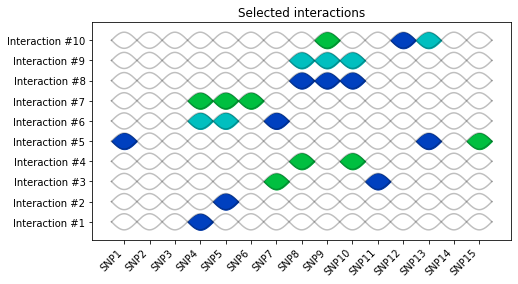

In [7]:
# Patterns can also be plotted for an easier inspection (NB: matplotlib and numpy libraries are required)
import matplotlib.pyplot as plt
import numpy as np

colors = {0: [0,0.25,0.75], 1: [0,0.75,0.75], 2: [0,0.75,0.25]} # One color for each allele configuration

interactions = hiprs.selected[0]

snps = [hiprs.dummies_dict.inv_lab_map[x] for x  in hiprs.dummies_dict.inv_lab_map]
nsnps = len(snps)
nint = len(interactions)

x = np.linspace(0, nsnps, 100*nsnps)
plt.figure(figsize = (nsnps*0.5, 0.4*nint))
for i in range(nint):
    plt.plot(x, i+0.4*np.sin(np.pi*x), color = 'k', alpha = 0.25)
    plt.plot(x, i-0.4*np.sin(np.pi*x), color = 'k', alpha = 0.25)

for i in range(nint):
    obj = interactions[i]
    whos = obj.vars
    vals = [int(float(z)) for z in obj.values]
    for who, val in zip(whos, vals):
        index = 0
        while(who!=snps[index]):
            index +=1
        z = x[index*100:(index+1)*100]
        plt.fill_between(z, i+0.4*np.sin(np.pi*z), i-0.4*np.sin(np.pi*z), color = colors[val])

plt.xticks(np.arange(nsnps)+0.5, snps)
plt.xticks(rotation=45, ha="right")
plt.yticks(np.arange(nint), ['Interaction #%d' % (n+1) for n in range(nint)])
plt.title("Selected interactions")
plt.show()